<a href="https://colab.research.google.com/github/mohammedterry/ANNs/blob/master/ANN_NeuroEvo_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!curl -O https://pmcvariety.files.wordpress.com/2018/04/twitter-logo.jpg?w=100&h=100&crop=1
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3593  100  3593    0     0  29211      0 --:--:-- --:--:-- --:--:-- 29211
 sample_data  'twitter-logo.jpg?w=100'


In [0]:
from PIL import Image
image = Image.open('twitter-logo.jpg?w=100')

In [0]:
import numpy as np
image_array = np.asarray(image)

In [0]:
training_inputs,training_outputs = [],[]
for row,rgbs in enumerate(image_array):
  for column,rgb in enumerate(rgbs):
    training_inputs.append(np.array([row,column]))
    r,g,b = rgb
    training_outputs.append(np.array([r/255,g/255,b/255]))

# NeuroEvolution

In [0]:
import numpy as np
import random

class FFNN:
  def __init__(self, weights):
    self.weights = weights
  
  def _f(self,x): #activation function: sigmoid
    return 1. / (1. + np.exp(-x))
  
  def __call__(self, x): #forward pass through each layer in the deep ffnn
    for w in self.weights:
      x = self._f(x @ w)
    return x

class GA:
  evolutionary_history = [0]
  #hyperparameters
  n_hidden = 15
  max_generations = 100
  population_size = 40
  p_perturb_weight = .8
  p_mutate_weight = .08
  p_mutate_layer = .3
  p_add_layer = .03

  def __init__(self,n_inputs,n_outputs,x_test,y_test):
    self.n_inputs, self.n_outputs = n_inputs,n_outputs 
    self.genomes = [[np.random.rand(self.n_inputs,self.n_hidden),np.random.rand(self.n_hidden,self.n_outputs)] for _ in range(self.population_size)]  #each genome is a 2D matrix of synapse weights for each layer in ffnn
    self.x_test = x_test
    self.y_test = y_test
    
  def fitness(self, weights):
    ann = FFNN(weights)
    y_predicted = np.array([ann(x) for x in self.x_test])
    difference = np.sum((self.y_test - y_predicted)**2) 
    return 1/difference
  
  def rank(self,genomes):
    self.fitnesses = [self.fitness(genome) for genome in genomes]
    self.evolutionary_history.append( max(self.fitnesses) )
    return [genomes[i] for _,i in sorted(zip(self.fitnesses,[i for i in range(len(self.fitnesses))]), reverse=True)] #rank genomes by fitness

  def mutate(self,genomes):
    def noise(x):
      return x + np.random.uniform(-.1,.1) if np.random.random() <= self.p_perturb_weight else np.random.uniform(-1,1) if np.random.random() <= self.p_mutate_weight else x
    noise = np.vectorize(noise) 

    for i,weights in enumerate(genomes):   
      genomes[i] = [noise(layer) if random.random() <= self.p_mutate_layer else layer for layer in weights] #change some weights
      if np.random.random() <= self.p_add_layer: #add another hidden layer 
        pointer = np.random.randint(1,len(weights)) #add it inbetween the input and output layers
        genomes[i] = weights[:pointer] + [np.random.rand(self.n_hidden,self.n_hidden)] + weights[pointer:]                  
    return genomes
  
  def crossover(self,genome1,genome2): #one-point crossover
    pointer1 = np.random.randint(1,len(genome1))
    pointer2 = np.random.randint(1,len(genome2))
    new_genome1 = genome1[:pointer1] + genome2[pointer2:]
    new_genome2 = genome2[:pointer2] + genome1[pointer1:]
    return new_genome1, new_genome2
  
  def mate(self,genome1,genome2):
    child1,child2 = self.crossover(genome1,genome2)
    return genome1, genome2, child1, child2 # returns x2 parents & x2 children (i.e. mixtures of both parents)
  
  def g_algorithm(self):
    self.best_genome = self.rank(self.genomes)[0]
    fitness_total = sum(self.fitnesses)
    elite_indexes = np.random.choice(len(self.genomes), (self.population_size // 4) -1, p= [f/fitness_total for f in self.fitnesses]) #randomly sample quarter of new population from the old using fitness to determine probability of being sampled 
    elites = [self.genomes[i] for i in elite_indexes]
    offspring = [child for parent1,parent2 in zip(elites,random.sample(elites, len(elites))) for child in self.mate(parent1,parent2) ]  #elite's offspring replace population (4 children for every genome)
    self.genomes = self.mutate(offspring) + [self.best_genome] + [[np.random.rand(self.n_inputs,self.n_hidden), np.random.rand(self.n_hidden,self.n_outputs)] for _ in range(3)] #new population is offspting and the best parent (in case all children are worse) and three new random genomes (in case the current gene pool simply isnt good enough)
    
  def evolve(self):
    for generation in range(self.max_generations):
      self.g_algorithm()
      print(generation, self.evolutionary_history[-1])
      

In [76]:
g = GA(2,3,training_inputs,training_outputs)
g.evolve()
best_weight = g.best_genome

0 0.00150147577113586
1 0.00150147577113586
2 0.0015317640094908533
3 0.001534356533170726
4 0.001534356533170726
5 0.0015429940583092927
6 0.001561307313473308
7 0.0015821887428587086
8 0.0015821887428587086
9 0.0015821887428587086
10 0.0015821887428587086
11 0.0015821887428587086
12 0.0015821887428587086
13 0.0015821887428587086
14 0.0015821887428587086
15 0.0015821887428587086
16 0.0015821887428587086
17 0.0015978443255750862
18 0.0015978443255750862
19 0.0016423755453072548
20 0.0016423755453072548
21 0.0016423755453072548
22 0.0016527948423254726
23 0.0016583560334180116
24 0.0016583560334180116
25 0.0016985950496715176
26 0.0016985950496715176
27 0.0016985950496715176
28 0.0016985950496715176
29 0.0016985950496715176
30 0.0016985950496715176
31 0.0016994040535708874
32 0.0017205148201031766
33 0.0017648068406323882
34 0.0017648068406323882
35 0.0017648068406323882
36 0.0019931735071931447
37 0.0019931735071931447
38 0.0019931735071931447
39 0.0019931735071931447
40 0.001993173507

Text(0, 0.5, 'fitness')

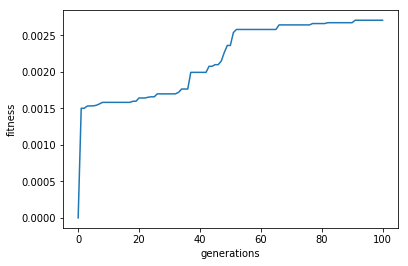

In [77]:
import matplotlib.pyplot as plt
plt.plot(g.evolutionary_history)
plt.xlabel('generations')
plt.ylabel('fitness')

In [78]:
best_weight

[array([[ 0.17749836,  0.82330385,  0.01902527, -0.01617827,  0.63177517,
         -0.74614883,  0.48955901,  0.29894383,  0.1858499 ,  0.22357493,
          0.82476691, -0.01051267,  0.57468158,  0.19227818,  0.35489571],
        [-0.25830201,  0.5444552 ,  1.10750747,  0.64444155,  0.03999434,
          0.46368436,  0.2464137 ,  0.79703966, -1.01470426,  0.39851383,
          0.4352035 ,  0.95307887, -1.00647265, -0.27563203,  0.5795193 ]]),
 array([[ 0.99180653,  0.1768239 ,  0.21542426],
        [-0.52555643,  0.23787003,  0.68611409],
        [ 0.19535684, -0.83931887,  0.2592691 ],
        [ 0.39653012,  0.28008232,  0.66812452],
        [-0.44971883,  0.52762128,  0.40719681],
        [ 0.55145044,  0.04411138,  0.44887554],
        [ 0.86300905,  0.21536917,  0.25954058],
        [-0.16158686,  0.55611227,  0.3786964 ],
        [-0.11132294,  0.36178391,  0.33234205],
        [ 0.51391635,  0.55060686, -0.67012014],
        [ 0.2372081 , -0.00699378,  0.4482029 ],
        [ 0.5

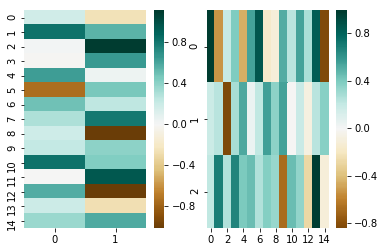

In [93]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, len(best_weight))
import pandas as pd
import seaborn as sns
for layer in range(len(best_weight)):
  sns.heatmap(pd.DataFrame({f'{i}':w for i,w in enumerate(best_weight[layer])}),center=0,cmap="BrBG",ax=axes[layer])

In [79]:
evolved_ann = FFNN(best_weight)
evolved_ann([1,1])

array([0.84013744, 0.84588341, 0.93937476])

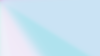

In [80]:
predicted_outputs = evolved_ann(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)

# Extreme Learning Machine

In [0]:
import numpy as np

class ELM:
  def __init__(self, n_inputs: int, n_hidden = 3000):
    self.random_weights = np.random.normal(size=[n_inputs, n_hidden])
    
  def learn(self, X: np.ndarray, Y: np.ndarray):
    H = self._hidden_layer(X)
    self.output_weights = np.linalg.pinv(H) @ Y
    
  def _f(self, x: np.ndarray): 
    return 1. / (1. + np.exp(-x)) #activation function: sigmoid
    
  def _hidden_layer(self, inputs: np.ndarray): 
    return self._f(inputs @ self.random_weights)
  
  def _output_layer(self, hidden: np.ndarray): 
    return hidden @ self.output_weights
  
  def __call__(self, inputs: np.ndarray):  #infer
    return self._output_layer(self._hidden_layer(inputs))

In [0]:
elm = ELM(2)
elm.learn(np.array(training_inputs), np.array(training_outputs))

In [0]:
elm([1,1])

array([0.95012379, 0.94977713, 0.94932604])

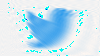

In [0]:
predicted_outputs = elm(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)